<a href="https://colab.research.google.com/github/zyntonyson/Erisk2017/blob/master/04_LSTM_Early_Detection_Depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early deteccion Depression (LSTM)




In [0]:
#Activar almacenamiento google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import os
mypath='/content/drive/My Drive/MCE/Participaciones/05.Estancia Jun19/Practicas NLP/Deteccion de depresion/Actualizacion sep 2019'
os.chdir( mypath )

In [0]:
import numpy as np
import pandas as pd
train_df=pd.read_csv('train_Depression_all_chunks_nosteem.csv')
train_df=train_df.replace(np.nan, '', regex=True)
test_df=pd.read_csv('test_Depression_all_chunks_nosteem.csv')
test_df=test_df.replace(np.nan, '', regex=True)

In [0]:
def generate_data(df,nchunks=1):
  data=df['Chunk_1']
  data.rename(columns={'Chunk_1': 'x'})
  if nchunks<=1:
   pass
  else:
    for i in range(2,nchunks):
      chunk='Chunk_'+str(i)
      data+=df[chunk]
  return data.values

In [0]:
# Selección de datos de entrenamiento
x_train=generate_data(train_df,10)
y_train=train_df['Depress'].values
x_test=generate_data(test_df,10)
y_test=test_df['Depress'].values

In [0]:
# Determinar la frase más larga para igualar secuencias
phrase_len=[len(p.split(' ')) for p in  (list(x_train.flatten()))]
max_phrase=max(phrase_len)
max_phrase

49490

(array([292.,  71.,  55.,  29.,  20.,  10.,   1.,   5.,   0.,   3.]),
 array([1.00000e+00, 4.94990e+03, 9.89880e+03, 1.48477e+04, 1.97966e+04,
        2.47455e+04, 2.96944e+04, 3.46433e+04, 3.95922e+04, 4.45411e+04,
        4.94900e+04]),
 <a list of 10 Patch objects>)

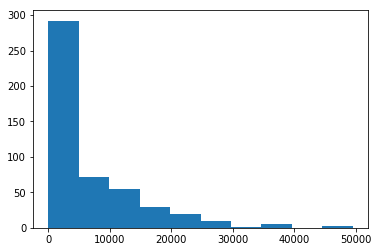

In [0]:
import matplotlib.pyplot as plt
plt.hist(phrase_len,density=False)

In [0]:
j=30000
sum(i>j for i in phrase_len)

9

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


Using TensorFlow backend.


In [0]:
max_words=10000
max_len= 30000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)
X_train= pad_sequences(X_train,maxlen=max_len)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D


In [0]:
#Métricas
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
# Arquitectura LSTM

model_lstm=Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 50, input_length = max_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(100, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(1, activation = 'sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy',f1_m,precision_m, recall_m]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30000, 50)         500000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30000, 50)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 560,501
Trainable params: 560,501
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
#Entrenamiento

epochs=30
batch_size=32
history=model_lstm.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2)




Train on 388 samples, validate on 98 samples
Epoch 1/30





 64/388 [===>..........................] - ETA: 4:33 - loss: 0.6917 - acc: 0.5781 - f1_m: 0.0870 - precision_m: 0.0556 - recall_m: 0.2000

## Referencias

* https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc

* https://machinelearningmastery.com/keras-functional-api-deep-learning/

* https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

* https://medium.com/@panghalarsh/sentiment-analysis-in-python-using-keras-glove-twitter-word-embeddings-and-deep-rnn-on-a-combined-580646cb900a

* https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras

* https://mc.ai/understanding-input-and-output-shape-in-lstm-keras/

* https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa